# Z calibration with machine learning
In this notebook, I will use the data that is obtained from bead calibration movie. The movie consists of fluorescent diffraction limited spots. These spots are fit to a 2D Gaussian, to obtain their width in x and y dimension as a function of z. Using this data, I used Linear Regression to train a model to predict the z location from the width  in x and y.

## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

### Reading the data in as a pandas dataframe

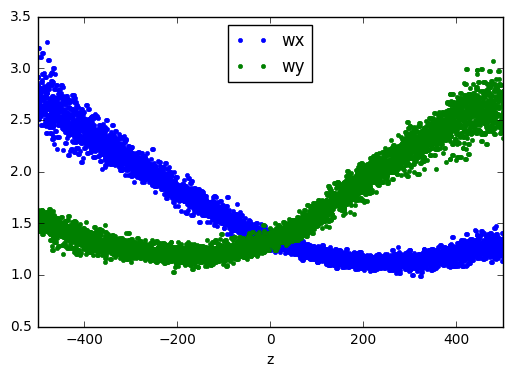

In [2]:
data = pd.read_excel('Z calibration.xlsx',header=None,names = ['z','wx','wy'])
data.index=data['z']
del data['z']
data.plot(style='.')
plt.show()

In [3]:
data.head()

,wx,wy
z,,
-500,2.91416,1.50648
-498,2.91416,1.50648
-496,2.82149,1.47510
-494,2.80901,1.43531
-492,2.80901,1.43531


As seen above the data contain an index which is the the z position, and 2 columns that are the width obtained in x(wx) and y(wy) at those z positions. This data was already processed to remove traces that were not of good quality.

In [4]:
#pixel_size = 88
pixel_size=1
X = data[['wx','wy']]*pixel_size #These are the features 
y =data.index # This is the variable we want to predict (the z position)

### Create Training and Test data set from X and y

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print ("Total points in dataset = {}".format(X.shape[0]))
print ("Points in training dataset = {}".format(X_train.shape[0]))
print ("Points in test dataset = {}".format(X_test.shape[0]))

Total points in dataset = 6480
Points in training dataset = 5832
Points in test dataset = 648


## Perform Linear Regression
### Training the model

In [6]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
print("Coefficients : {}".format(regr.coef_))
print ("Intercept : {}".format(regr.intercept_))


Coefficients : [-359.88218146  296.61192947]
Intercept : 79.55211429267706


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Predicting z for test data

In [7]:
pred1 = regr.predict(X_test)

### Comparing predictions to test data

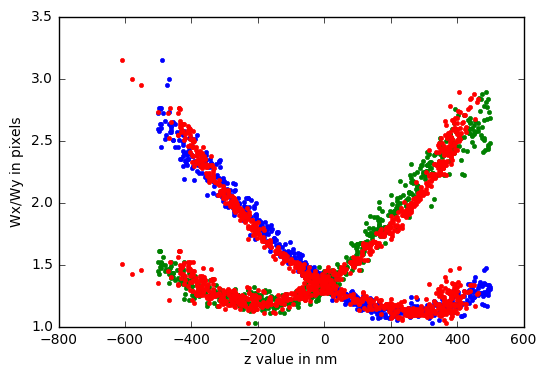

In [8]:
plt.plot (y_test,X_test.wx,'.b')
plt.plot(y_test,X_test.wy,'.g')

plt.plot (pred1,X_test.wx,'.r')
plt.plot (pred1,X_test.wy,'.r')
plt.xlabel('z value in nm')
plt.ylabel('Wx/Wy in pixels')

The predictions agree very well with the test data, except near the x limits (-400, 400). Let's check the r score and mean squared error. 

In [9]:
print ('r2_score : {}'.format(metrics.r2_score(y_test,pred1)))
print ('Mean sqd error : {}'.format(metrics.mean_squared_error(y_test,pred1)))
print ('Explained variance score : {}'.format(metrics.explained_variance_score(y_test,pred1)))


r2_score : 0.978766695642958
Mean sqd error : 1662.5710224641916
Explained variance score : 0.9787669209028548


The numbers above suggest that the linear regression model is a good representation of the data , and can be used for prediction.

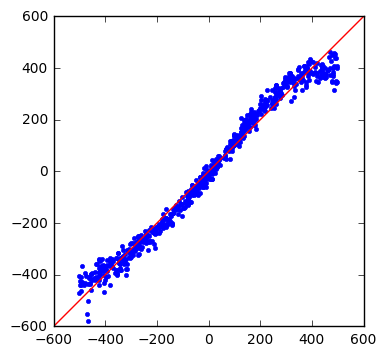

In [10]:
#Plotting expected vs predicted values. This is like a correlation plot.
plt.plot(X_test.index,pred1,'.b')
plt.plot([-600,600],[-600,600],'r')
plt.axis([-600, 600, -600, 600])
plt.axes().set_aspect('equal')


The points are mostly along the diagonal, however there is some deviation from linearity for points <-200 and >200

### Lets see if Polynomial Regression works better

In [11]:
# First we will have to transform the data. We will use polynomial of degree 2. We will use same Train and Test data.
X_train_d2 = PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_train)
X_test_d2 = PolynomialFeatures(degree=2,include_bias=False).fit_transform(X_test)
print ("Shape of X_train_d2 = {}".format(X_train_d2.shape)) # It now has 6 features rather than 2.

Shape of X_train_d2 = (5832, 5)


Initially we only had $wx$, and $wy$. Now we have $wx$, $wy$, $wx^2$, $wy^2$, and $wx*wy$.

In [12]:
#Performing regression
regr2 = linear_model.LinearRegression(fit_intercept=True) 
regr2.fit(X_train_d2,y_train)
print("Coefficients : {}".format(regr2.coef_))
print ("Intercept : {}".format(regr2.intercept_))

Coefficients : [-416.86020821 -164.64447508   -9.04843813   55.53353111  103.35740505]
Intercept : 512.232063676434


### Predicting z for test data

In [13]:
pred2 = regr2.predict(X_test_d2)

#### Comparing prediction results to test data

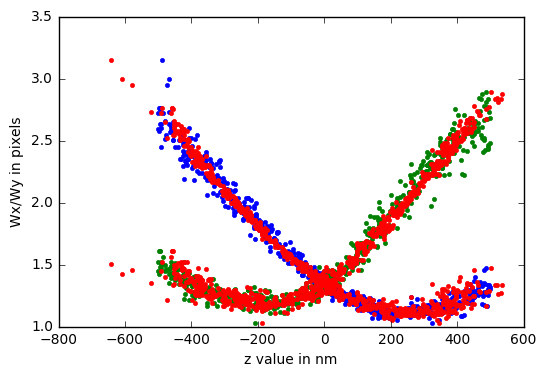

In [14]:
plt.plot (y_test,X_test.wx,'.b')
plt.plot(y_test,X_test.wy,'.g')

plt.plot (pred2,X_test.wx,'.r')
plt.plot (pred2,X_test.wy,'.r')
plt.xlabel('z value in nm')
plt.ylabel('Wx/Wy in pixels')

In [15]:
print ('r2_score : {}'.format(metrics.r2_score(y_test,pred2)))
print ('Mean sqd error : {}'.format(metrics.mean_squared_error(y_test,pred2)))
print ('Explained variance score : {}'.format(metrics.explained_variance_score(y_test,pred2)))


r2_score : 0.9856581375099466
Mean sqd error : 1122.9700560582316
Explained variance score : 0.985658503379809


In [18]:
from sklearn.feature_selection import f_regression
F_select = f_regression(X_test_d2,y_test)
print ("F-score for each variable : {}".format(F_select[0]))
print ("p-values for each F-score : {}".format(F_select[1]))

F-score for each variable : [ 2581.55369988  1660.23687402  1988.56048482    11.93389901  1526.0991794 ]
p-values for each F-score : [  7.65516675e-228   1.13475498e-180   2.36529976e-199   5.87279066e-004
   2.92413089e-172]


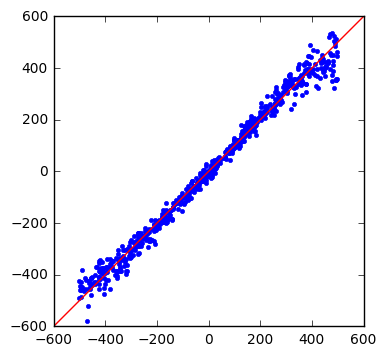

In [20]:
#Plotting expected vs predicted values. This is like a correlation plot.
plt.plot(X_test.index,pred2,'.b')
plt.plot([-600,600],[-600,600],'r')
plt.axis([-600, 600, -600, 600])
plt.axes().set_aspect('equal')

p-values suggest that polynomial of degree = 2 is definitely a better model. The plot shown above as hows that in points do not deviate significantly from the diagonal compared to the plot in which only linear regression was used.